# Лабораторная работа 4.1.1

#### Исследование центрированных оптических систем

### Библиотеки 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import math as m
import random as r

from scipy.optimize import curve_fit
from scipy.integrate import quad

In [2]:
def Line(x, a, b):
    """
    Параметрическая прямая
    """
    return a*x + b

#-----------------------------------------------------------------------------------------------------------
#
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! ВНИМАНИЕ !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#
# Тупой питон не может подставить знак минус перед коэффициентом b! Если экспонента имеет вид e(^b), b < 0,
# то минус надо указать вручную.
#
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#
#-----------------------------------------------------------------------------------------------------------
def Exponent(x, a, b, c):
    """
    Параметрическая експонента (ae^(bx)
    """
    return a * np.exp(-b * x) + c

def CalcErrors(popt, cov, precA = 4, precB = 4, printRes = True):
    """
    Вычисляет погрешность МНК.
    Выводит в консоль значения + погрешность.
    Возвращает массив погрешностей.
    """
    errors = []
    for i in range(len(popt)):
        try:
          errors.append(np.absolute(cov[i][i])**0.5)
        except:
          errors.append( 0.00 )
    errors = np.array(errors)

    if (printRes == True):
        print("a = {:.0{prec}f} sig_a = {:.0{prec}f}".format(popt[0], errors[0], prec = precA))
        print("b = {:.0{prec}f} sig_b = {:.0{prec}f}".format(popt[1], errors[1], prec = precB), '\n')

    return errors

def NpToStrList(np_array, precision):
    np_array = np.around(np_array.astype(float), precision)

    return ["{:.0{prec}f}".format(val, prec = precision) for val in np_array]

def NpToStr(array):
    return [str(f) for f in array]

def PrintMinMax(array, header):
    print(header + "min = {:.3f}, max = {:.3f}".format(min(array), max(array)))
    
#jnb.HideCell()

In [3]:
def _getIndex(indexRow, indexColumn, isRowDataSet):
    """
    Возвращает индексы в правильном порядке для обращения к массиву.
    """
    if (isRowDataSet == True):
        return (indexRow, indexColumn)
    else:
        return (indexColumn, indexRow)

def _drawRowGrid(file, rowGrid, rowIndex):
    if (rowGrid != None and rowGrid[rowIndex] > 0):
         file.write("\\hline\n" * rowGrid[rowIndex])

def _getTableDim(data, isRowDataSet):
    if (isRowDataSet == True):
        return (len(data), len(data[0]))
    else:
        return (len(data[0]), len(data))

def _createTable(fileName, data, isRowDataSet, 
                 columnGrid = None, rowGrid = None, preheader = None):
    """
    Создаёт вертикальную Latex-таблицу, если rowDataSet == false и горизонтальную, если rowDataSet == true.

    Аргументы:
    fileName     - имя выходного файла с таблицей;
    data         - массив данных таблицы;
    isRowDataSet - если true, массив данных содержит горизонтальную таблицу, иначе вертикальную;
    columnGrid   - строка, которая определяет тип сетки между колонками: \begin{tabular}{columnGrid};
    rowGrid      - список длины rowCount + 1, в котором содержится число:
                        - 0 - нет       горизонтальной линии;
                        - 1 - одинарная горизонтальная линия;
                        - 2 - двойная   горизонтальная линия.
    """
    rowCount, columnCount = _getTableDim(data, isRowDataSet)

    with open("tables\\" + fileName, 'w', encoding='utf-8') as file:

        if (columnGrid == None):
            columnGrid = "|" + 'c|' * columnCount
        
        file.write("\\begin{tabular}[t]{" + columnGrid +"}\n")

        _drawRowGrid(file, rowGrid, 0)
        
        if (preheader != None):
            file.write(preheader)

        for rowIndex in range(0, rowCount):

            for colIndex in range(0, columnCount - 1):
                index1, index2 = _getIndex(rowIndex, colIndex, isRowDataSet)

                file.write("{} & ".format(str(data[index1][index2]).replace('.', ',')))

            index1, index2 = _getIndex(rowIndex, columnCount - 1, isRowDataSet)

            file.write("{} \\\\ \n".format(str(data[index1][index2]).replace('.', ',')))

            _drawRowGrid(file, rowGrid, rowIndex + 1)

        # End data draw cycle
        file.write('\end{tabular}')

def CreateVerticalTable(fileName, data, 
                 columnGrid = None, rowGrid = None, preheader = None):
    """
    Создаёт вертикальную Latex-таблицу.
    """
    _createTable(fileName, data, False, columnGrid = columnGrid, rowGrid = rowGrid, preheader = preheader)

def CreateVerticalTableHeader(fileName, header, dataColumns, 
                 columnGrid = None, rowGrid = None, preheader = None):
    """
    Создаёт вертикальную Latex-таблицу.
    """
    _createTable(fileName, [[header[st]] + dataColumns[st] for st in range(0, len(dataColumns))],
                                False, columnGrid = columnGrid, rowGrid = rowGrid, preheader = preheader)

def CreateHorizontalTable(fileName, dataRows, 
                 columnGrid = None, rowGrid = None, preheader = None):
    """
    Создаёт горизонтальную Latex-таблицу.
    """
    _createTable(fileName, dataRows, True, columnGrid = columnGrid, rowGrid = rowGrid, preheader = preheader)
    

### Определение фокусных расстояний тонких линз методом Аббе

In [90]:
# f  - расстояние от линзы до изображения, см.
# d  - расстояние от линзы до предмета, см.
# fd - расстояние от изображения до предмета, fd = f + d, см.
# a  - размер предмета, см.
# b  - размер изображения, см.

abbe = {
    "a" : 2,
    "sig_r" : 0.05,
    "samples" : [
        { # 1
            "f"  : 17.8,
            "fd" : 41.4 + 1.3,
            "b"  : 1.5,
        },
        { # 2
            "f"  : 28.1,
            "fd" : 43.2 + 1.3,
            "b"  : 3.6,
        },
        { # 3
            "f"  : 22,
            "fd" : 40.2 + 1.3,
            "b"  : 2.4,
        },
        { # 4
            "f"  : 37.1,
            "fd" : 50.3 + 1.3,
            "b"  : 5.2,
        },
        { # 5
            "f"  : 58.1,
            "fd" : 69.5 + 1.3,
            "b"  : 9.3,
        },
        { # 6
            "f"  : 50.4,
            "fd" : 62.2 + 1.3,
            "b"  : 7.8,
        },
    ],
    "points" : [],
    "f" : [],
    "f'": [],
    "sig_f" :[],
    "sig_f'":[],
    "n"     : np.array(range(1, 6)),
    "avg_f" : 0,
    "avg_f'": 0,
    "sig_avg_f" : 0,
    "sig_avg_f'": 0,
    "eps_avg_f" : 0,
    "eps_avg_f'": 0
}

for sample in abbe["samples"]:
    sample["d"] = sample["fd"] - sample["f"]

for st in range(1, len(abbe["samples"])):
    prev = abbe["samples"][st - 1]
    curr = abbe["samples"][st]
    point = dict()
    point["dx'"]   = abs(curr["f"] - prev["f"])
    point["dx"]    = abs(curr["d"] - prev["d"])
    point["dy/y'"] = abs(abbe["a"]/curr["b"] - abbe["a"]/prev["b"])
    point["dy'/y"] = abs(curr["b"]/abbe["a"] - prev["b"]/abbe["a"])
    point["f"]     = point["dx"] / point["dy/y'"]
    point["f'"]    = point["dx'"] / point["dy'/y"]

    point["sig_dx'"] = (2)**0.5 * abbe["sig_r"]
    point["sig_dx"]  = (2)**0.5 * abbe["sig_r"]
    point["sig_dy/y'"] = ((abbe["sig_r"])**2/(curr["b"])**4 + (abbe["sig_r"])**2/(prev["b"])**4)**0.5 * abbe["a"]
    point["sig_dy'/y"] = (2)**0.5 * abbe["sig_r"] / abbe["a"]

    point["eps_dx'"] = point["sig_dx'"] / point["dx'"]
    point["eps_dx"]  = point["sig_dx"]  / point["dx"]
    point["eps_dy/y'"] = point["sig_dy/y'"] / point["dy/y'"]
    point["eps_dy'/y"] = point["sig_dy'/y"] / point["dy'/y"]

    point["eps_f"] = (point["eps_dx"]**2 + point["eps_dy/y'"]**2)**0.5
    point["sig_f"] = point["eps_f"] * point["f"]

    point["eps_f'"] = (point["eps_dx'"]**2 + point["eps_dy'/y"]**2)**0.5
    point["sig_f'"] = point["eps_f'"] * point["f'"]

    print("dx      = ", point["dx"],
        "\ndx'     = ", point["dx'"],
        "\ndy/y'   = ", point["dy/y'"],
        "\ndy'/y   = ", point["dy'/y"],
        "\nf       = ", point["f"], "\t+- ", point["sig_f"],
        "\nf'      = ", point["f'"], "\t+- ", point["sig_f'"],
        "\n\n")
    
    abbe["avg_f"] += point["f"]
    abbe["avg_f'"] += point["f'"]

    abbe["points"].append(point)
    abbe["f"].append(point["f"])
    abbe["f'"].append(point["f'"])
    abbe["sig_f"].append(point["sig_f"])
    abbe["sig_f'"].append(point["sig_f'"])

abbe["avg_f"] /= max(abbe["n"])
abbe["avg_f'"] /= max(abbe["n"])

for point in abbe["points"]:
    abbe["sig_avg_f"] += (point["f"] - abbe["avg_f"])**2
    abbe["sig_avg_f'"] += (point["f'"] - abbe["avg_f'"])**2

abbe["sig_avg_f"] = (1 / (max(abbe["n"]) * (max(abbe["n"]) - 1) ) * abbe["sig_avg_f"])**0.5
abbe["sig_avg_f'"] = (1 / (max(abbe["n"]) * (max(abbe["n"]) - 1) ) * abbe["sig_avg_f'"])**0.5

abbe["f"] = np.array(abbe["f"])
abbe["f'"] = np.array(abbe["f'"])
abbe["sig_f"] = np.array(abbe["sig_f"])
abbe["sig_f'"] = np.array(abbe["sig_f'"])

dx      =  8.499999999999996 
dx'     =  10.3 
dy/y'   =  0.7777777777777777 
dy'/y   =  1.05 
f       =  10.928571428571425 	+-  0.6403181659978021 
f'      =  9.80952380952381 	+-  0.33709906456504557 


dx      =  3.1000000000000014 
dx'     =  6.100000000000001 
dy/y'   =  0.2777777777777778 
dy'/y   =  0.6000000000000001 
f       =  11.160000000000005 	+-  0.8046155914472456 
f'      =  10.166666666666668 	+-  0.6105584622314797 


dx      =  5.000000000000007 
dx'     =  15.100000000000001 
dy/y'   =  0.4487179487179488 
dy'/y   =  1.4000000000000001 
f       =  11.142857142857157 	+-  0.46811665737785846 
f'      =  10.785714285714286 	+-  0.27702366805273354 


dx      =  1.7999999999999972 
dx'     =  21.0 
dy/y'   =  0.1695616211745244 
dy'/y   =  2.0500000000000003 
f       =  10.615609756097545 	+-  0.4824445795179918 
f'      =  10.243902439024389 	+-  0.1800072187562418 


dx      =  0.4000000000000057 
dx'     =  7.700000000000003 
dy/y'   =  0.04135649296939625 
dy'/y  

In [94]:
print(abbe["avg_f"], "\t+-", abbe["sig_avg_f"])
print(abbe["avg_f'"],"\t+-", abbe["sig_avg_f'"])

10.703807665505252 	+- 0.2760254126544738
10.254494773519164 	+- 0.1562317921906286


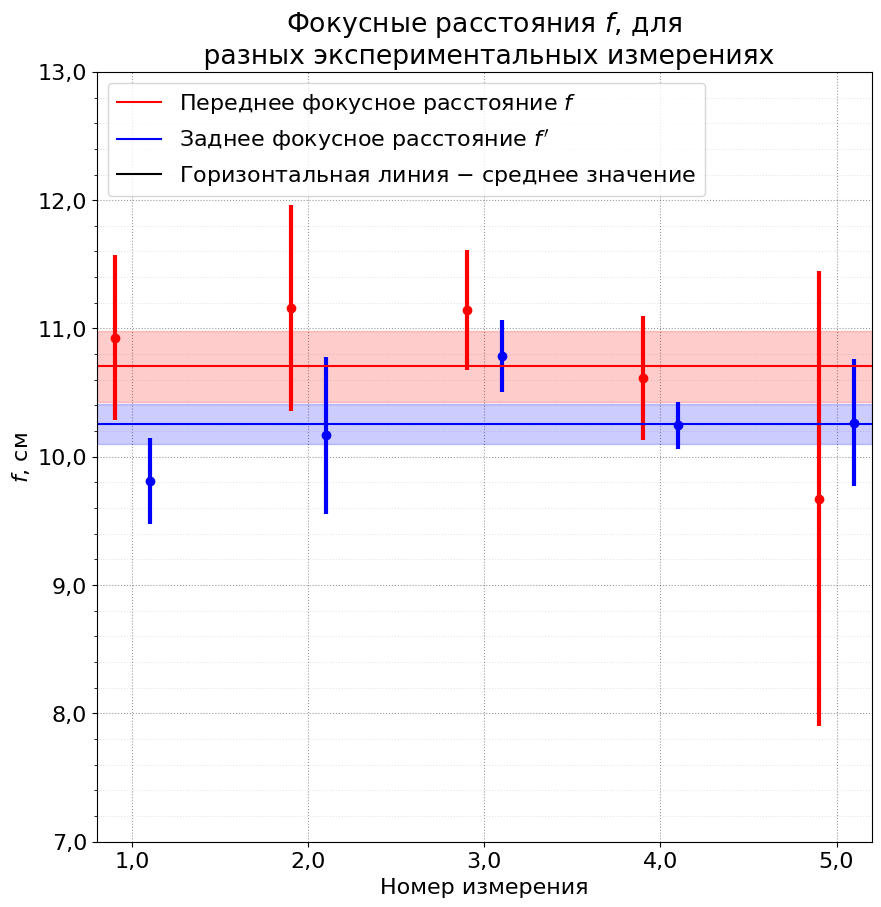

In [98]:
xMin = 0.8
xMax = 5.201

yMin = 7
yMax = 13.001

plotTitle       = 'Фокусные расстояния $f$, для\n разных экспериментальных измерениях'

xLabel          = r'Номер измерения'
yLabel          = r'$f$, см'

xMinorStep      = 0
xMajorStep      = 1

yMinorStep      = 0.2
yMajorStep      = 1

xTickMultiplier = 1
yTickMultiplier = 1

xPrecision      = 1
yPrecision      = 1

# Построение графика.

mpl.rcParams['font.size'] = 16

fig  = plt.figure(figsize = (10,10), dpi = 100)
axes = fig.add_subplot()

fig.set_facecolor("white")

# Заголовок

plt.title(plotTitle)
plt.xlabel(xLabel)
plt.ylabel(yLabel)

# Линии

x = np.array([xMin, xMax])

plt.errorbar(abbe["n"] - 0.1, abbe["f"], yerr = abbe["sig_f"], fmt = 'o', linewidth = 3, color = 'red')
plt.errorbar(abbe["n"] + 0.1, abbe["f'"], yerr = abbe["sig_f'"], fmt = 'o', linewidth = 3, color = 'blue')

plt.plot(x, np.array([abbe["avg_f"]]  * 2), color = 'red', label = "Переднее фокусное расстояние $f$")
plt.plot(x, np.array([abbe["avg_f'"]] * 2), color = 'blue', label = "Заднее фокусное расстояние $f'$")

rect_f1 = mpl.patches.Rectangle((xMin, abbe["avg_f"] - abbe["sig_avg_f"]),
                               xMax - xMin, 2 * abbe["sig_avg_f"],
                               color = 'red',
                               alpha = 0.2)
axes.add_patch(rect_f1)

rect_f2 = mpl.patches.Rectangle((xMin, abbe["avg_f'"] - abbe["sig_avg_f'"]),
                               xMax - xMin, 2 * abbe["sig_avg_f'"],
                               color = 'blue',
                               alpha = 0.2)
axes.add_patch(rect_f2)

plt.plot(0, 0, color = 'black', label = "Горизонтальная линия $-$ среднее значение")

# Оформление масштабных чёрточек

if yMajorStep > 0:
    y_major_ticks = np.arange(yMin, yMax, yMajorStep)
    axes.set_yticks(y_major_ticks)

if yMinorStep > 0:
    y_minor_ticks = np.arange(yMin, yMax, yMinorStep)
    axes.set_yticks(y_minor_ticks, minor = True)

if xMajorStep > 0:
    x_major_ticks = np.arange(1, 5.001, xMajorStep)
    axes.set_xticks(x_major_ticks)

if xMinorStep > 0:
    x_minor_ticks = np.arange(xMin, xMax, xMinorStep)
    axes.set_xticks(x_minor_ticks, minor = True)

# Пределы графика

plt.xlim([xMin, xMax])
plt.ylim([yMin, yMax])

# Форматирование чёрточек

def xTickFormatter(tickVal, position):
    return "{:.{prec}f}".format(tickVal * xTickMultiplier, prec = xPrecision).replace('.', ',')

def yTickFormatter(tickVal, position):
    return "{:.{prec}f}".format(tickVal * yTickMultiplier, prec = yPrecision).replace('.', ',')

axes.xaxis.set_major_formatter(ticker.FuncFormatter(xTickFormatter))
axes.yaxis.set_major_formatter(ticker.FuncFormatter(yTickFormatter))

# Легенда
plt.legend(loc = 'upper left')

# Сетка
plt.grid(which='major', linestyle = ':', c = 'black', alpha = 0.4)
plt.grid(which='minor', linestyle = ':', c = 'black', alpha = 0.1)

# Вывод
plt.savefig("Графики/f.png")
plt.show()